# Outlier

- 이상치 : 극단적인 값, 전체 데이터 범위를 넘는 값
- 이상치를 제거하는 것이 문제가 될 수 있음

- if 이상치가 데이터 분석 기준에 대한 이상치라면 -> 실제 군집일 수도
- ex) 백화점 고객데이터 -> 일반 고객 vs vip

- 이상치에 대한 군집이 형성된다면 -> 두 개의 군집으로 나눠서 분석할 수도 있음

---

- 정답이 있는 부분이 아니기 때문에 단순하게 수치적으로 접근해서 이상치를 제거, 성능 개선, 일반화할 수 있는 것이 아님 -> 목적에 맞게 이상치 제거에 대한 방법을 생각해야 됨

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## 예시 데이터를 통해 Outlier 확인

In [29]:
from sklearn import datasets

dataset = datasets.fetch_california_housing()
df = pd.DataFrame(dataset.data, columns = dataset.feature_names)
df['target'] = dataset.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


<Axes: >

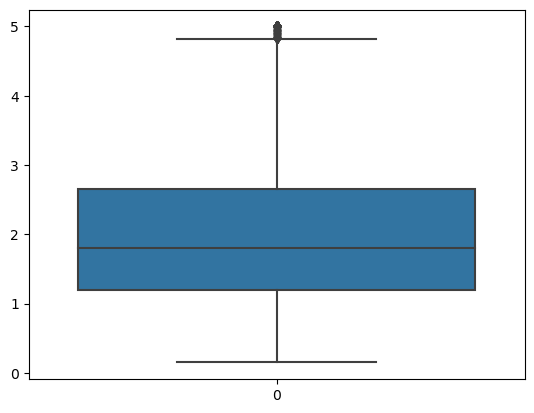

In [5]:
sns.boxplot(df.target)

<Axes: >

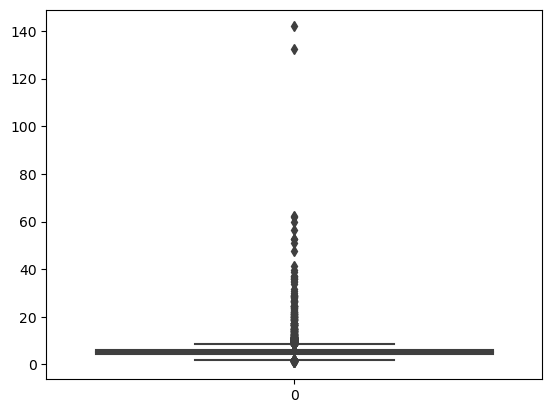

In [6]:
sns.boxplot(df.AveRooms)

In [7]:
df.AveRooms.describe()

count    20640.000000
mean         5.429000
std          2.474173
min          0.846154
25%          4.440716
50%          5.229129
75%          6.052381
max        141.909091
Name: AveRooms, dtype: float64

In [8]:
df.target.describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: target, dtype: float64

In [9]:
# 최대값의 인덱스 추출
np.argmax(df.AveRooms)

1914

In [10]:
df.iloc[1914]

MedInc          1.875000
HouseAge       33.000000
AveRooms      141.909091
AveBedrms      25.636364
Population     30.000000
AveOccup        2.727273
Latitude       38.910000
Longitude    -120.100000
target          5.000010
Name: 1914, dtype: float64

### 이상치를 제거하지 않고 회귀분석의 RMSE 정도를 낮출 순 없을까?

### 가중치나 새로운 변수를 만들면 성능이 좋아질까?

In [40]:
df_sp = df[['AveRooms', 'HouseAge', 'Population', 'target']]

In [41]:
df_sp1 = df_sp.copy()
df_sp2 = df_sp.copy()
df_sp3 = df_sp.copy()

In [60]:
x_train, x_test, y_train, y_test = train_test_split(df_sp.drop('target', axis = 1), df_sp['target'], 
                                                    test_size = 0.3, random_state = 111)

### 베이스

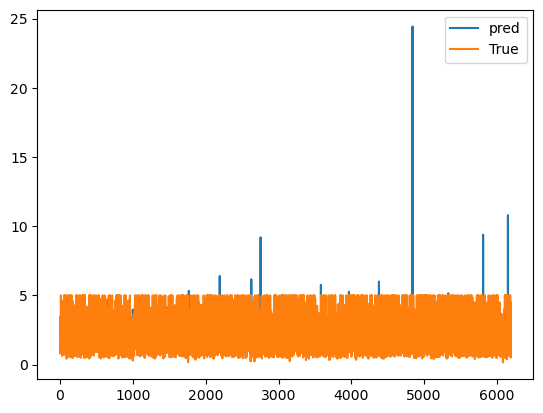

In [61]:
fit_train1 = sm.OLS(y_train, x_train)
fit_train1 = fit_train1.fit()

plt.plot(np.array(fit_train1.predict(x_test)), label = 'pred')
plt.plot(np.array(y_test), label = 'True')
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(y_true = y_test, y_pred = fit_train1.predict(x_test))
print(mse1)

1.3737537935478012


- 베이스라인 모델로 회귀분석 진행 시 1.3

## AveRooms 이상치 제거

- IQR(사분범위) 방식
- 통계치에 대한 개념으로 제거

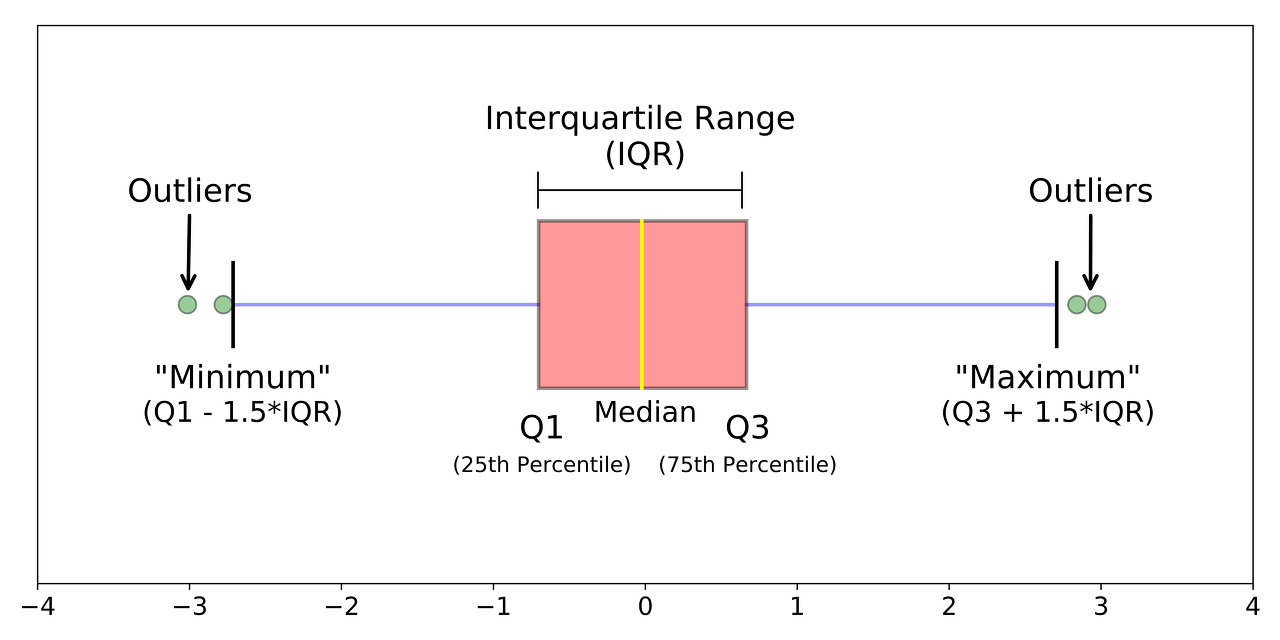

In [15]:
# 이상치 추출

Q1 = df_sp['AveRooms'].quantile(0.25)
Q3 = df_sp['AveRooms'].quantile(0.75)
IQR = Q3 - Q1
rev_range = 3 # 이상치를 Q1 - 3*IQR 미만, Q3 + 3*IQR 초과로 판단
filter1 = (df_sp['AveRooms'] >= (Q1 - rev_range * IQR)) & (df_sp['AveRooms'] <= (Q3 + rev_range * IQR))

In [16]:
df_sp_rmv = df_sp.loc[filter1]

In [17]:
df_sp_rmv
# 이상치 제외한 Dataframe

,AveRooms,HouseAge,Population,target
0,6.984127,41.0,322.0,4.526
1,6.238137,21.0,2401.0,3.585
2,8.288136,52.0,496.0,3.521
3,5.817352,52.0,558.0,3.413
4,6.281853,52.0,565.0,3.422
...,...,...,...,...
20635,5.045455,25.0,845.0,0.781
20636,6.114035,18.0,356.0,0.771
20637,5.205543,17.0,1007.0,0.923
20638,5.329513,18.0,741.0,0.847


이상치 제거하기

In [42]:
def replace_outlier(value):
    Q1 = df_sp['AveRooms'].quantile(0.25)
    Q3 = df_sp['AveRooms'].quantile(0.75)
    IQR = Q3 - Q1
    rev_range = 3
    
    if value < (Q1 - rev_range * IQR):
        value = np.nan
    if value > (Q3 + rev_range * IQR):
        value = np.nan
    return value

df_sp1.AveRooms = df_sp1.AveRooms.apply(replace_outlier)

In [43]:
df_sp1.isna().sum()

AveRooms      180
HouseAge        0
Population      0
target          0
dtype: int64

In [44]:
df_sp1= df_sp1.dropna()

In [55]:
df_sp1

,AveRooms,HouseAge,Population,target
0,6.984127,41.0,322.0,4.526
1,6.238137,21.0,2401.0,3.585
2,8.288136,52.0,496.0,3.521
3,5.817352,52.0,558.0,3.413
4,6.281853,52.0,565.0,3.422
...,...,...,...,...
20635,5.045455,25.0,845.0,0.781
20636,6.114035,18.0,356.0,0.771
20637,5.205543,17.0,1007.0,0.923
20638,5.329513,18.0,741.0,0.847


이상치를 제거한 데이터 회귀분석 모델 돌리기

In [56]:
# train, test 분리
x_train, x_test, y_train, y_test = train_test_split(df_sp1.drop(['target'], axis = 1), df_sp1['target'],
                                                    test_size = 0.3, random_state = 111)

In [57]:
fit_train2 = sm.OLS(y_train, x_train)
fit_train2 = fit_train2.fit()
y_pred = fit_train2.predict(x_test)

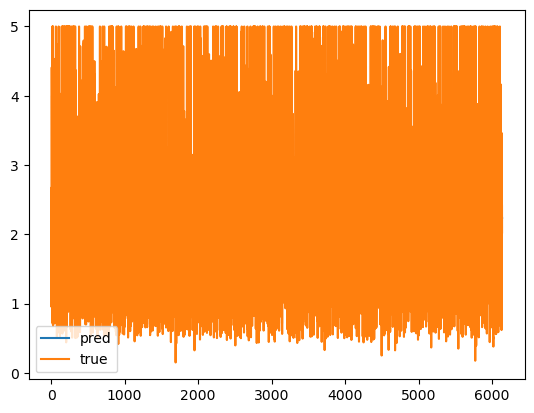

In [58]:
plt.plot(np.array(y_pred), label = 'pred')
plt.plot(np.array(y_test), label = 'true')
plt.legend()
plt.show()

In [59]:
mse2 = mean_squared_error(y_true = y_test, y_pred = y_pred)
print(mse2)

1.1694755604062264


## 이상치를 살려서 분석하는 경우

- 이상치에 가중치를 둔다 : 0 (이상치가 아닌 경우) 1 (이상치인 경우)

In [46]:
def saving_outlier(value):
    Q1 = df_sp['AveRooms'].quantile(0.25)
    Q3 = df_sp['AveRooms'].quantile(0.75)
    IQR = Q3 - Q1
    rev_range = 3
    
    if value < (Q1 - rev_range * IQR):
        value = 1
    elif value > (Q3 + rev_range * IQR):
        value = 1
    else:
        value = 0
    return value

df_sp2['AveRooms_sv'] = df_sp2['AveRooms'].apply(saving_outlier)

In [47]:
df_sp2.AveRooms_sv.value_counts()

0    20460
1      180
Name: AveRooms_sv, dtype: int64

In [48]:
df_sp2.AveRooms_sv.sum()

180

In [49]:
# train, test 나누기
x_train, x_test, y_train, y_test = train_test_split(df_sp2.drop('target', axis = 1), df_sp2['target'],
                                                   test_size = 0.3, random_state = 111)

In [50]:
fit_train3 = sm.OLS(y_train, x_train)
fit_train3 = fit_train3.fit()
y_pred = fit_train3.predict(x_test)

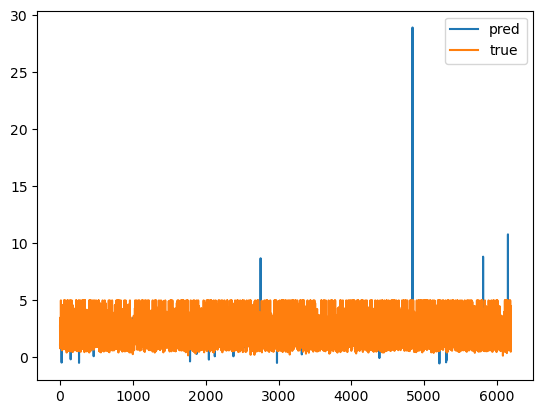

In [52]:
plt.plot(np.array(y_pred), label = 'pred')
plt.plot(np.array(y_test), label = 'true')
plt.legend()
plt.show()

In [54]:
mse3 = mean_squared_error(y_true = y_test, y_pred = y_pred)
print(mse3)

1.3195403300827175


In [63]:
print(mse1, ': 기존 base')
print(mse2, ': outlier 제거')
print(mse3, ': outlier 보존')

1.3737537935478012 : 기존 base
1.1694755604062264 : outlier 제거
1.3195403300827175 : outlier 보존
